In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
# Correct import for plotting cross-validation metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import logging
import warnings

# Suppress Prophet's verbose logging and other warnings for cleaner output
logging.getLogger('prophet').setLevel(logging.WARNING)
warnings.filterwarnings('ignore')


c:\Users\vighn\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
print("--- Retail Sales Forecasting Project (Daily, Weekly, Monthly) ---")
print("This script will forecast sales using the Prophet library,")
print("leveraging your 'sales_data_sample.csv' dataset at different frequencies.")
print("\n")

# --- 1. Data Loading ---
# Load your sales data from the provided CSV file.
# Make sure the 'sales_data_sample.csv' file is in the same directory as this script.
try:
    # Attempt to load the CSV.
    # We're assuming column names like 'ORDERDATE' and 'SALES'.
    # IMPORTANT: If your CSV uses different column names, please modify the lines below.
    df_raw = pd.read_csv('sales_data_sample.csv', encoding='latin1')
    print("Successfully loaded 'sales_data_sample.csv'.")
    print(f"Raw data shape: {df_raw.shape}")
    print("First 5 rows of raw data:")
    print(df_raw.head())
    print("\n")

    # --- Identify and Rename Columns for Prophet ---
    # Prophet requires two columns: 'ds' (datestamp) and 'y' (target variable).
    date_column = 'ORDERDATE'
    sales_column = 'SALES'

    if date_column not in df_raw.columns:
        print(f"Error: '{date_column}' not found in CSV columns. Please check your CSV header.")
        print(f"Available columns: {df_raw.columns.tolist()}")
        exit()
    if sales_column not in df_raw.columns:
        print(f"Error: '{sales_column}' not found in CSV columns. Please check your CSV header.")
        print(f"Available columns: {df_raw.columns.tolist()}")
        exit()

    df = df_raw[[date_column, sales_column]].copy()
    df.rename(columns={date_column: 'ds', sales_column: 'y'}, inplace=True)

    # Convert 'ds' column to datetime objects
    df['ds'] = pd.to_datetime(df['ds'])

    # Ensure 'y' column is numeric
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df.dropna(subset=['y'], inplace=True) # Drop rows where sales data is missing/non-numeric

except FileNotFoundError:
    print("Error: 'sales_data_sample.csv' not found.")
    print("Please make sure the CSV file is in the same directory as this script.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading or initial processing: {e}")
    exit()

print("Data prepared for initial processing (ds, y):")
print(df.head())
print(f"Processed data range: {df['ds'].min()} to {df['ds'].max()}")
print("\n")

--- Retail Sales Forecasting Project (Daily, Weekly, Monthly) ---
This script will forecast sales using the Prophet library,
leveraging your 'sales_data_sample.csv' dataset at different frequencies.


Successfully loaded 'sales_data_sample.csv'.
Raw data shape: (2823, 25)
First 5 rows of raw data:
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:

In [3]:
# --- 2. Data Aggregation for Daily, Weekly, and Monthly ---
print("--- Aggregating Data to Daily, Weekly, and Monthly Sales ---")

# Aggregate to daily sales
df_daily = df.groupby('ds')['y'].sum().reset_index()
print(f"Aggregated daily data shape: {df_daily.shape}")
print("First 5 rows of aggregated daily data:")
print(df_daily.head())
print("\n")

# Aggregate to weekly sales (end of week, Sunday by default)
# For weekly, it's often better to resample and sum to ensure all dates are covered
df_weekly = df.set_index('ds').resample('W')['y'].sum().reset_index()
print(f"Aggregated weekly data shape: {df_weekly.shape}")
print("First 5 rows of aggregated weekly data:")
print(df_weekly.head())
print("\n")

# Aggregate to monthly sales (start of month)
df_monthly = df.set_index('ds').resample('MS')['y'].sum().reset_index()
print(f"Aggregated monthly data shape: {df_monthly.shape}")
print("First 5 rows of aggregated monthly data:")
print(df_monthly.head())
print("\n")


--- Aggregating Data to Daily, Weekly, and Monthly Sales ---
Aggregated daily data shape: (252, 2)
First 5 rows of aggregated daily data:
          ds         y
0 2003-01-06  12133.25
1 2003-01-09  11432.34
2 2003-01-10   6864.05
3 2003-01-29  54702.00
4 2003-01-31  44621.96


Aggregated weekly data shape: (126, 2)
First 5 rows of aggregated weekly data:
          ds         y
0 2003-01-12  30429.64
1 2003-01-19      0.00
2 2003-01-26      0.00
3 2003-02-02  99323.96
4 2003-02-09      0.00


Aggregated monthly data shape: (29, 2)
First 5 rows of aggregated monthly data:
          ds          y
0 2003-01-01  129753.60
1 2003-02-01  140836.19
2 2003-03-01  174504.90
3 2003-04-01  201609.55
4 2003-05-01  192673.11




In [4]:
# --- 3. Forecasting Function ---
def perform_forecasting(data_df, freq_name, forecast_periods, cv_initial, cv_period, cv_horizon):
    """
    Performs Prophet forecasting, cross-validation, and visualization for a given DataFrame.

    Args:
        data_df (pd.DataFrame): DataFrame with 'ds' and 'y' columns.
        freq_name (str): Name of the frequency (e.g., 'Daily', 'Weekly', 'Monthly').
        forecast_periods (int): Number of periods to forecast into the future.
        cv_initial (str): Initial training period for cross-validation (e.g., '730 days').
        cv_period (str): Period between cutoff dates for cross-validation.
        cv_horizon (str): Forecast horizon for cross-validation.
    """
    print(f"=== Starting Forecasting for {freq_name} Sales ===")

    # Ensure data_df has enough data for cross-validation
    # Prophet requires at least 2 full periods for initial training + horizon for CV
    min_data_points = 2 * pd.to_timedelta(cv_initial).days / (7 if 'W' in cv_initial else 1) # Crude estimate
    if len(data_df) < min_data_points and freq_name != 'Daily': # Daily usually has enough data
        print(f"Warning: Not enough data points ({len(data_df)}) for robust cross-validation for {freq_name} sales.")
        print("Skipping cross-validation for this frequency.")
        perform_cv = False
    else:
        perform_cv = True


    # --- Model Training ---
    m = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        weekly_seasonality=(freq_name == 'Daily'), # Weekly seasonality only relevant for daily data
        yearly_seasonality=True,
        daily_seasonality=False # Generally not needed unless very granular data and strong daily patterns
    )

    # For monthly data, weekly seasonality is not applicable, but yearly is.
    # For weekly data, yearly seasonality is applicable.
    # Prophet automatically handles seasonality based on frequency for yearly/weekly if enabled.

    m.fit(data_df)
    print(f"Prophet model trained successfully for {freq_name} sales.")

    # --- Future Dataframe for Forecasting ---
    future = m.make_future_dataframe(periods=forecast_periods)
    print(f"Created future dataframe for {freq_name} sales.")

    # --- Making Predictions ---
    forecast = m.predict(future)
    print(f"Generated forecast for {freq_name} sales.")

    # --- Model Evaluation: Cross-Validation & Performance Metrics ---
    if perform_cv:
        print(f"--- Performing Time Series Cross-Validation for {freq_name} Sales ---")
        try:
            df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon=cv_horizon)
            df_p = performance_metrics(df_cv)
            print(f"Performance Metrics for {freq_name} Sales (averaged over cutoffs):")
            print(df_p.head())

            # Plot performance metrics
            # Corrected: Call plot_cross_validation_metric directly from prophet.plot
            fig_rmse = plot_cross_validation_metric(df_cv, metric='rmse')
            plt.title(f'{freq_name} Sales: RMSE over Forecast Horizon')
            plt.xlabel(f'Horizon ({cv_horizon.split(" ")[1]})')
            plt.ylabel('RMSE')
            plt.show()

            # Corrected: Call plot_cross_validation_metric directly from prophet.plot
            fig_mae = plot_cross_validation_metric(df_cv, metric='mae')
            plt.title(f'{freq_name} Sales: MAE over Forecast Horizon')
            plt.xlabel(f'Horizon ({cv_horizon.split(" ")[1]})')
            plt.ylabel('MAE')
            plt.show()
            print(f"Visualized RMSE and MAE over forecast horizons for {freq_name} sales.")
        except ValueError as e:
            print(f"Error during cross-validation for {freq_name} sales: {e}")
            print("This usually means there isn't enough historical data for the chosen cross-validation parameters.")
    else:
        print(f"Skipping cross-validation due to insufficient data for {freq_name} sales.")

    # --- Visualization of Forecast and Components ---
    print(f"--- Visualizing Final Forecast and Components for {freq_name} Sales ---")

    # Plot the main forecast
    fig_forecast = m.plot(forecast)
    plt.title(f'{freq_name} Sales Forecast with Uncertainty Interval')
    plt.xlabel('Date')
    plt.ylabel(f'{freq_name} Sales')
    plt.plot(data_df['ds'], data_df['y'], 'o', markersize=4, color='darkred', label=f'Actual {freq_name} Sales')
    plt.legend()
    plt.show()

    # Plot the individual components
    fig_components = m.plot_components(forecast)
    plt.suptitle(f'{freq_name} Sales Forecast Components', y=1.02) # Add a main title for component plots
    plt.show()
    print(f"Visualized overall forecast and its components for {freq_name} sales.")
    print(f"=== {freq_name} Sales Forecasting Complete! ===\n")



11:33:45 - cmdstanpy - INFO - Chain [1] start processing


=== Starting Forecasting for Daily Sales ===


11:33:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully for Daily sales.
Created future dataframe for Daily sales.
Generated forecast for Daily sales.
--- Performing Time Series Cross-Validation for Daily Sales ---


  0%|          | 0/1 [00:00<?, ?it/s]11:33:45 - cmdstanpy - INFO - Chain [1] start processing
11:33:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


Performance Metrics for Daily Sales (averaged over cutoffs):
  horizon           mse          rmse           mae      mape     mdape  \
0  2 days  7.178969e+08  26793.597367  26756.114190  0.410913  0.410913   
1  7 days  3.305307e+08  18180.502279  14847.894345  0.269198  0.269198   
2  8 days  3.805636e+08  19508.039927  15799.421254  1.614197  1.614197   
3 13 days  3.943794e+08  19858.988285  17034.783562  1.704952  1.704952   
4 15 days  8.918756e+07   9443.916353   9153.026945  0.435138  0.435138   

      smape  coverage  
0  0.517181       1.0  
1  0.327469       1.0  
2  0.674231       1.0  
3  0.740665       1.0  
4  0.352708       1.0  


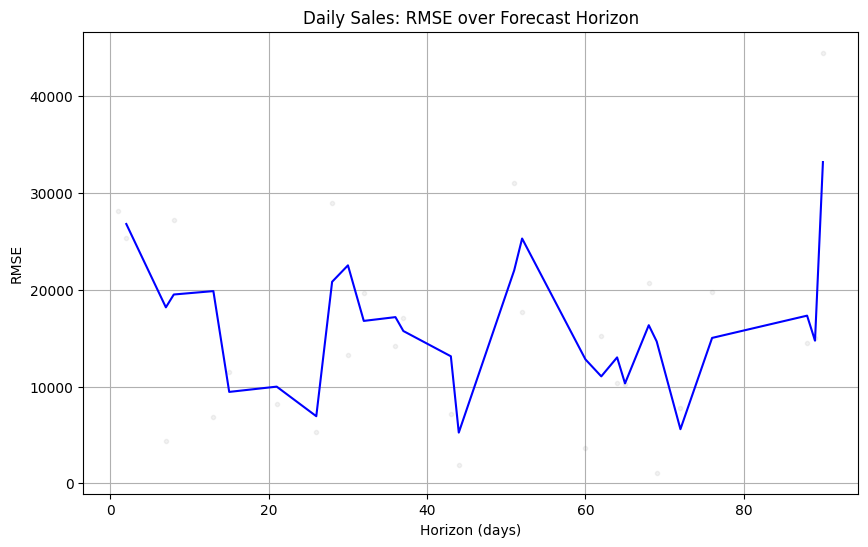

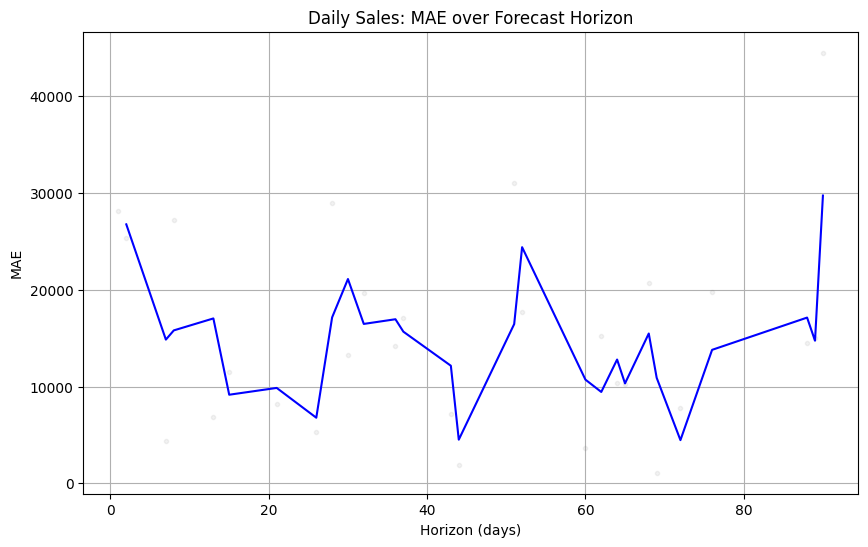

Visualized RMSE and MAE over forecast horizons for Daily sales.
--- Visualizing Final Forecast and Components for Daily Sales ---


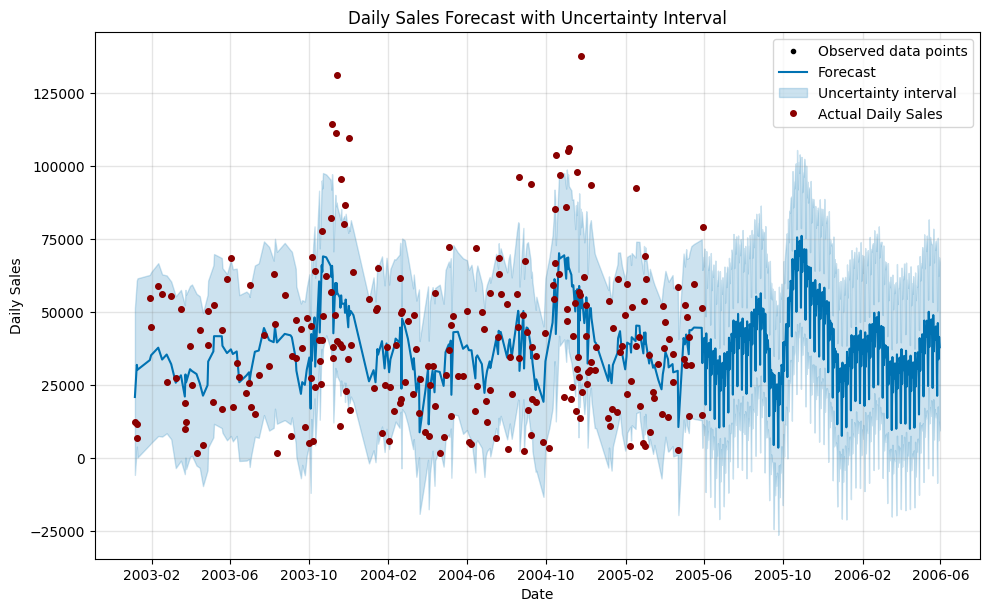

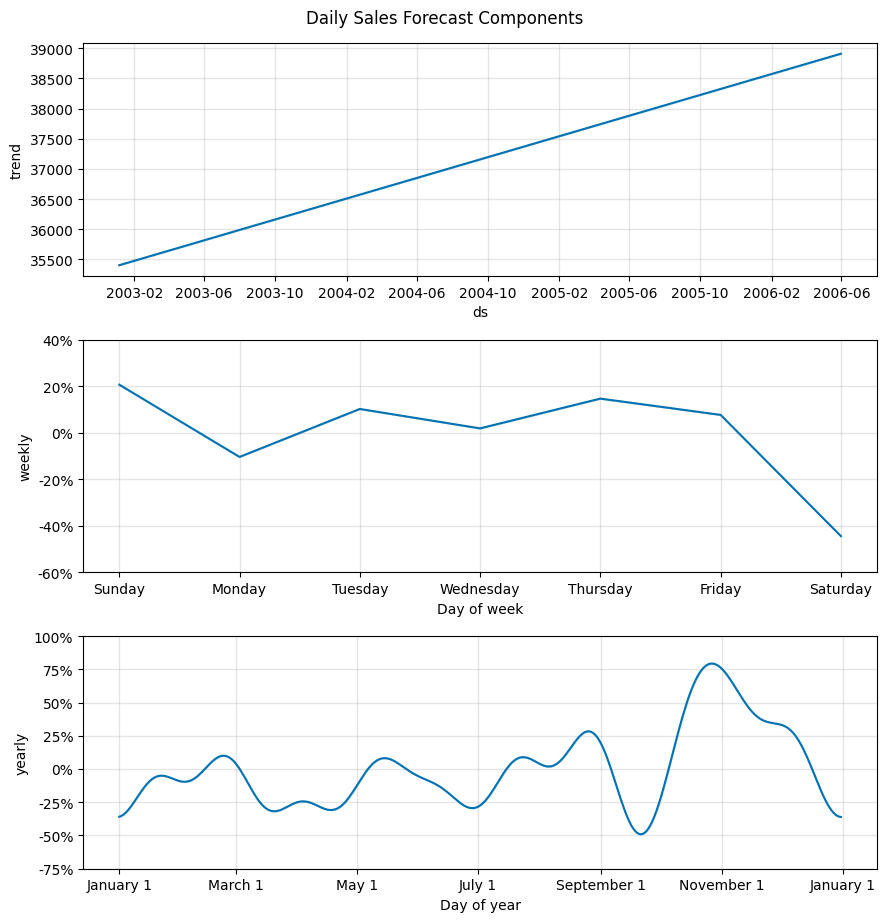

Visualized overall forecast and its components for Daily sales.
=== Daily Sales Forecasting Complete! ===

=== Starting Forecasting for Weekly Sales ===


ValueError: invalid unit abbreviation: weeks

In [5]:
# --- 4. Run Forecasting for Each Frequency ---

# Daily Sales Forecasting
perform_forecasting(
    data_df=df_daily,
    freq_name='Daily',
    forecast_periods=365, # 1 year forecast
    cv_initial='730 days', # 2 years initial training
    cv_period='180 days',  # 6 months between cutoffs
    cv_horizon='90 days'   # 3 months forecast horizon for CV
)

# Weekly Sales Forecasting
# Ensure there's enough data for weekly aggregation and forecasting
if len(df_weekly) > 10: # Arbitrary threshold, adjust as needed
    perform_forecasting(
        data_df=df_weekly,
        freq_name='Weekly',
        forecast_periods=52,   # 1 year forecast
        cv_initial='104 weeks', # 2 years initial training
        cv_period='26 weeks',  # 6 months between cutoffs
        cv_horizon='12 weeks'  # 3 months forecast horizon for CV
    )
else:
    print("Not enough weekly data points to perform weekly sales forecasting.")
    print("Skipping weekly sales forecasting.")

# Monthly Sales Forecasting
# Ensure there's enough data for monthly aggregation and forecasting
if len(df_monthly) > 5: # Arbitrary threshold, adjust as needed
    perform_forecasting(
        data_df=df_monthly,
        freq_name='Monthly',
        forecast_periods=12,   # 1 year forecast
        cv_initial='24 months', # 2 years initial training
        cv_period='6 months',  # 6 months between cutoffs
        cv_horizon='3 months'  # 3 months forecast horizon for CV
    )
else:
    print("Not enough monthly data points to perform monthly sales forecasting.")
    print("Skipping monthly sales forecasting.")

print("--- All Forecasting Processes Completed ---")